<a href="https://colab.research.google.com/github/jjgranadat/Semillero_SOFA/blob/C%C3%A9sar/knn_svm_16QAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

# Generación y modulación

In [ ]:
# Número de símbolos
Ns = 5000
# 16-QAM
Mod = 16
sym_tx = np.random.randint(Mod, size = Ns)

In [ ]:
mod_dict = {0: -3+3j, #0000
            1: -3+1j, #0001
            2: -3-3j, #0010
            3: -3-1j, #0011
            4: -1+3j, #0100
            5: -1+1j, #0101
            6: -1-3j, #0110
            7: -1-1j, #0111
            8:  3+3j, #1000
            9:  3+1j, #1001
            10: 3-3j, #1010
            11: 3-1j, #1011
            12: 1+3j, #1100
            13: 1+1j, #1101
            14: 1-3j, #1110
            15: 1-1j} #1111


In [ ]:
X_tx = np.array([mod_dict[sym] for sym in sym_tx])

# Simulación de los efectos del canal

In [ ]:
def calc_noise(snr, X):
    X_avg_p = np.mean(np.power(X, 2))
    X_avg_db = 10 * np.log10(X_avg_p)

    noise_avg_db = X_avg_db - snr
    noise_avg_p = np.power(10, noise_avg_db / 10)
    # Al no poner el parámetro loc se asume media 0
    noise = np.random.normal(scale = np.sqrt(noise_avg_p), size = len(X))
    return X + noise

def add_awgn(snr, X):
    Xr = np.real(X)
    Xi = np.imag(X)
    return (calc_noise(snr, Xr), calc_noise(snr, Xi))

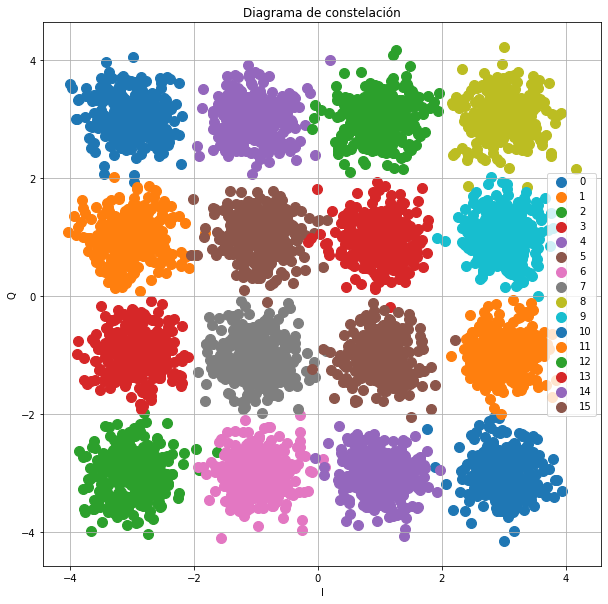

In [ ]:
Xr_ch, Xi_ch = add_awgn(16, X_tx)
X_ch = Xr_ch + 1j*Xi_ch

plt.figure(figsize = (10, 10))
for symbol in np.unique(sym_tx):
    ix = np.where(sym_tx == symbol)
    plt.scatter(Xr_ch[ix], Xi_ch[ix], label = symbol, s = 100)

plt.title("Diagrama de constelación")
plt.xlabel("I")
plt.ylabel("Q")
plt.grid(True)
plt.legend()
plt.show()

# Demodulación tradicional

In [ ]:
def demodulate(X_rx, mod_dict):
    demodulated = []
    # Diccionario para demodular
    demod_dict = dict(zip(mod_dict.values(), mod_dict.keys()))
    for x in X_rx:
        # Distancia a cada centroide
        dist = np.abs(np.array(list(mod_dict.values())) - x)
        # Índice del valor mínimo de distancia
        index = list(dist).index(np.min(dist))
        # Centroide más cercano al símbolo
        demodulated.append(index)
    return demodulated

# Demodulación usando KNN

In [ ]:
def demodulate_knn(X_rx, sym_tx, k):
    X = np.array([X_rx.real, X_rx.imag]).T
    y = sym_tx
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
    
    # Número de vecinos
    model = KNeighborsClassifier(n_neighbors = k)
    model.fit(X_train, y_train)
    return model.predict(X)

# Demodulación usando SVM

In [ ]:
def demodulate_svm(X_rx, sym_tx, C, gamma):
    X = np.array([X_rx.real, X_rx.imag]).T
    y = sym_tx
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

    model = SVC(C = C, gamma = gamma)
    model.fit(X_train, y_train)
    return model.predict(X)

# Encontrar los mejores parámetros para los algoritmos

In [ ]:
def find_best_params(estimator, param_grid, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

    grid = GridSearchCV(estimator(), param_grid, verbose = 0)
    
    grid.fit(X_train, y_train)
    
    return grid.best_params_

# Medidas de error BER y SER

In [ ]:
def SymbolErrorRate(sym_rx, sym_tx):
    error = 0
    for i in range(len(sym_tx)):
        if sym_rx[i] != sym_tx[i]:
            error += 1
    SER = error / len(sym_tx)
    return SER, error

def BitErrorRate(sym_rx, sym_tx):
    # Se transforman los símbolos a binario
    sym_rx_str = ''.join([f"{sym:04b}" for sym in sym_rx])
    sym_tx_str = ''.join([f"{sym:04b}" for sym in sym_tx])

    error = sum(sym_rx_str[i] != sym_tx_str[i] for i in range(len(sym_rx_str)))
    BER = error / len(sym_rx_str)
    return BER, error

In [ ]:
SNR = np.arange(1, 19, 2)
param_grid_knn = {'n_neighbors': [3, 5, 7, 9, 11, 13, 15]}
param_grid_svm = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}

trad_ser = []
knn_ser = []
svm_ser = []

trad_ber = []
knn_ber = []
svm_ber = []

for snr in SNR:
    Xr_ch, Xi_ch = add_awgn(snr, X_tx)
    X_ch = Xr_ch + 1j*Xi_ch

    X = np.array([X_ch.real, X_ch.imag]).T
    y = sym_tx

    # Encontrar el mejor parámetro
    best_params_knn = find_best_params(KNeighborsClassifier, param_grid_knn, X, y)
    best_params_svm = find_best_params(SVC, param_grid_svm, X, y)

    k = best_params_knn["n_neighbors"] 
    C = best_params_svm["C"]
    gamma = best_params_svm["gamma"]
    
    print(f"Mejores parámetros SNR {snr}dB: k = {k}, C = {C}, γ = {gamma}")
    
    # Demodulaciones
    # Debería solamente usarse las muestras para test, pero la cantidad
    # de datos es muy pequeña para eso.
    trad = demodulate(X_ch, mod_dict) 
    knn = demodulate_knn(X_ch, sym_tx, k)
    svm = demodulate_svm(X_ch, sym_tx, C, gamma)

    # Medida SER
    trad_ser.append(SymbolErrorRate(trad, sym_tx)[0])
    knn_ser.append(SymbolErrorRate(knn, sym_tx)[0])
    svm_ser.append(SymbolErrorRate(svm, sym_tx)[0])

    # Medida BER
    trad_ber.append(BitErrorRate(trad, sym_tx)[0])
    knn_ber.append(BitErrorRate(knn, sym_tx)[0])
    svm_ber.append(BitErrorRate(svm, sym_tx)[0])

Mejores parámetros SNR 1dB: k = 15, C = 100, γ = 0.001
Mejores parámetros SNR 3dB: k = 15, C = 1, γ = 0.001
Mejores parámetros SNR 5dB: k = 15, C = 1, γ = 0.01
Mejores parámetros SNR 7dB: k = 15, C = 1, γ = 0.01
Mejores parámetros SNR 9dB: k = 15, C = 100, γ = 0.001
Mejores parámetros SNR 11dB: k = 15, C = 0.1, γ = 0.1
Mejores parámetros SNR 13dB: k = 13, C = 10, γ = 0.001
Mejores parámetros SNR 15dB: k = 7, C = 0.1, γ = 0.1
Mejores parámetros SNR 17dB: k = 5, C = 0.1, γ = 1


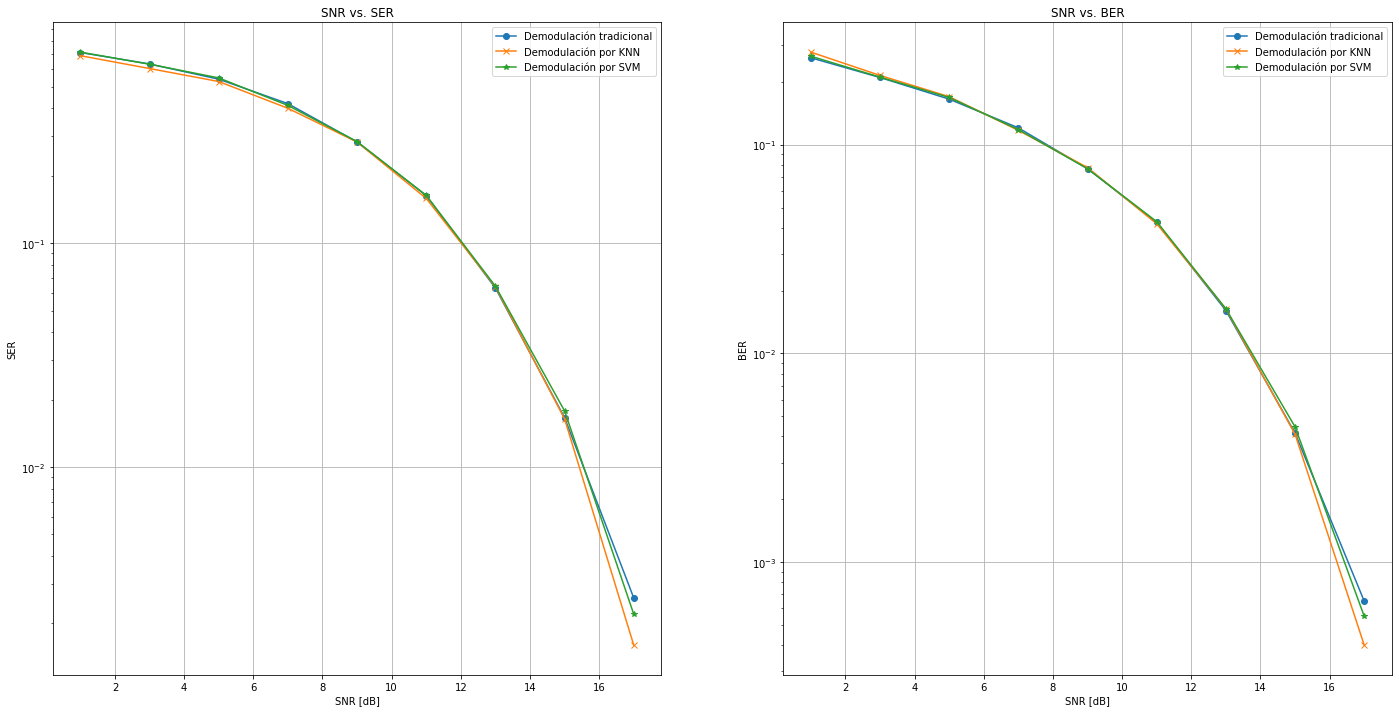

In [ ]:
# Gráfica
plt.figure(figsize = (24, 12))
plt.subplot(1, 2, 1)

plt.semilogy(SNR, trad_ser, marker = "o", label = "Demodulación tradicional")
plt.semilogy(SNR, knn_ser, marker = "x", label = "Demodulación por KNN")
plt.semilogy(SNR, svm_ser, marker = "*", label = "Demodulación por SVM")

plt.title("SNR vs. SER")
plt.xlabel("SNR [dB]")
plt.ylabel("SER")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)

plt.semilogy(SNR, trad_ber, marker = "o", label = "Demodulación tradicional")
plt.semilogy(SNR, knn_ber, marker = "x", label = "Demodulación por KNN")
plt.semilogy(SNR, svm_ber, marker = "*", label = "Demodulación por SVM")
plt.title("SNR vs. BER")
plt.xlabel("SNR [dB]")
plt.ylabel("BER")
plt.grid(True)
plt.legend()